<a href="https://colab.research.google.com/github/PJbourne/IA-course-tasks/blob/main/C%C3%B3pia_de_ArtigoIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning Aplicado a Finanças: Um Estudo de Caso Preditivo e Interpretativo do Câmbio BRL/USD utilizando Random Forest e Fatores Macroeconômicos

Alunos: Pablo Teodoro Monteiro, Rafaela Rodrigues Reis, Renata Canuto Ferreira
Matéria: Inteligência Artificial



---



##Escopo
Utilizando o dolar como "zero" juntamente com features macroeconômicas, queremos entender se o algoritmo random forest de machine learning terá bom desemprenho na previsão da valorização/desvalorização do Real no marcado financeiro.

1. Utilizamos dados históricos dos últimos 9 anos e 11 meses por questões de limitação da API utilizada (bcb)
2. Dados retirados do Yahoo Finance e pela biblioteca SGS do Banco do Brasil (BCB) com o auxilio das bibliotecas python-bcb e yfinance
  * **yfinance** - É uma biblioteca Python open code, que permite baixar dados históricos do mercado global diretamente do portal Yahoo Finance. É uma biblioteca criada por desenvolvedores com objetivo de manter a integridade dos dados e de ser uma forma mais "amigável" de acessá-los.
    * *Yahoo Finance* - É um dos maiores agregadores de dados financeiros do mundo. Ele coleta informações de diversas bolsas de valores e provedores de dados e as exibe em seu site público. A biblioteca yfinance simula o comportamento de um navegador acessando o site. Ela envia requisições da API para os servidores do Yahoo Finance, pedindo os dados históricos de cada ticker (ex: ^BVSP, BRL=X) no período especificado, entregando um arquivo JSON com os dados.
  * **python-bcb** - É uma biblioteca Python criada para ser uma interface direta e amigável com o SGS (Sistema Gerenciador de Séries Temporais) do Banco Central do Brasil (BCB).
    * *Banco de Dados do BCB*: O Banco Central do Brasil mantém um banco de dados público chamado SGS. Nele, cada indicador econômico (SELIC, IPCA, PIB, etc.) possui um código numérico único.







---



##Código Principal

In [ ]:
# Instalar bibliotecas
!pip install yfinance xgboost pandas numpy scikit-learn matplotlib seaborn python-bcb

In [ ]:
# Import dos métodos/recursos das bibliotecas
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bcb import sgs
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Declares das variáveis principais (BCB só deixa requisição dos últimos 10 anos)
start_date = '2015-08-01'
end_date = pd.to_datetime('today') + pd.Timedelta(days=1)
tickers = ['BRL=X', '^BVSP', '^GSPC', 'CL=F', 'GC=F', '^VIX']

In [ ]:
# Coleta dos dados e construção do dataset

# Baixa os dados de mercado do Yahoo Finance
data_mercado = yf.download(tickers, start=start_date, end=end_date)['Close']
data_mercado.rename(columns={
    'BRL=X': 'BRL_USD',
    '^BVSP': 'IBOVESPA',
    '^GSPC': 'SP500',
    'CL=F': 'Petroleo',
    'GC=F': 'Ouro',
    '^VIX': 'VIX'
}, inplace=True)

# Baixa a taxa SELIC diária do Banco Central do Brasil (código 11)
selic = sgs.get({'SELIC': 11}, start=start_date)
selic.rename(columns={'SELIC': 'SELIC'}, inplace=True)

# Combina os dois conjuntos de dados e cria um dataset bruto
df = pd.merge(data_mercado, selic, on='Date', how='left')

# Preenche os valores da SELIC para os dias sem alteração (fins de semana, etc.) (revisada a cada 45 dias)
df['SELIC'].ffill(inplace=True)

# Remove linhas com dados faltantes
df.dropna(inplace=True)

/tmp/ipython-input-168-395965551.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_mercado = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  6 of 6 completed
/tmp/ipython-input-168-395965551.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['SELIC'].ffill(inplace=True)


In [ ]:
# Vizuliza a tabela principal
df

,BRL_USD,Petroleo,Ouro,IBOVESPA,SP500,VIX,SELIC
Date,,,,,,,
2015-08-03,3.4194,45.169998,1089.400024,50138.000000,2098.040039,12.56,0.052531
2015-08-04,3.4488,45.740002,1090.699951,50058.000000,2093.320068,13.00,0.052531
2015-08-05,3.4663,45.150002,1085.699951,50287.000000,2099.840088,12.51,0.052531
2015-08-06,3.4838,44.660000,1090.199951,50011.000000,2083.560059,13.77,0.052531
2015-08-07,3.5316,43.869999,1094.099976,48577.000000,2077.570068,13.39,0.052531
...,...,...,...,...,...,...,...
2025-07-22,5.5655,66.209999,3439.199951,134036.000000,6309.620117,16.50,0.055131
2025-07-23,5.5639,65.250000,3394.100098,135368.000000,6358.910156,15.37,0.055131
2025-07-24,5.5164,66.029999,3371.000000,133808.000000,6363.350098,15.39,0.055131


In [ ]:
df.head()
# Pega apenas as 5 primeiras linhas
df_head = df.head()

df_head.style.set_caption("Tabela 2: Exploração dos dados formatados")\
             .set_table_styles([{'selector': 'caption', 'props': [('font-size', '20px')]}])\
             .format("{:.2f}")\
             .highlight_max(color='lightgreen', axis=0)\
             .highlight_min(color='#FFCCCB', axis=0)

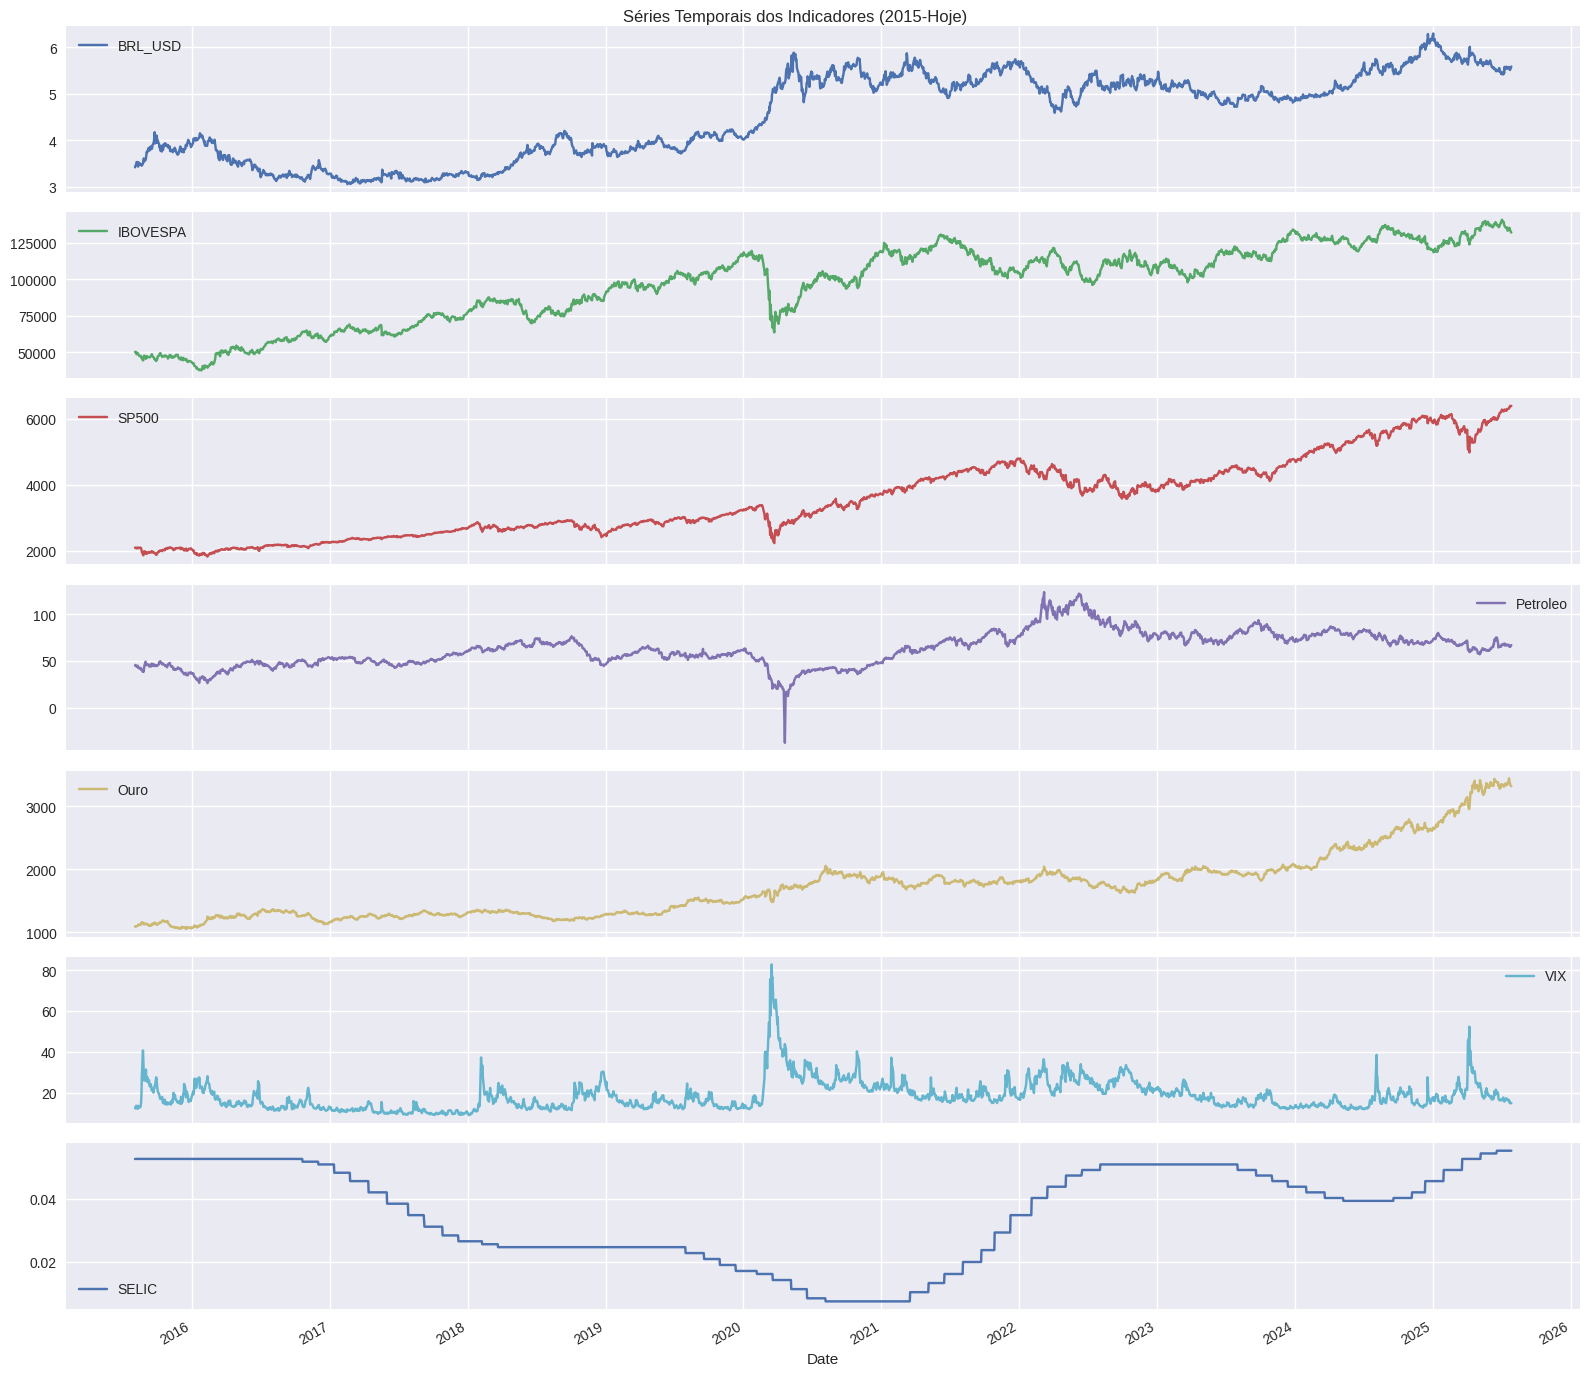

In [ ]:
# Gráficos dos parâmetros que estamos usando (ajuda a ver a variação ao longo do tempo)

# Seleciona as colunas
colunas_para_plotar = ['BRL_USD', 'IBOVESPA', 'SP500', 'Petroleo', 'Ouro', 'VIX', 'SELIC']

# Cria os gráficos
df[colunas_para_plotar].plot(
    subplots=True,
    layout=(-1, 1),       # Organiza os gráficos em uma grade com 2 colunas
    figsize=(16, 14),     # Tamanho da figura geral
    title='Séries Temporais dos Indicadores (2015-Hoje)',
    grid=True,            # Adiciona uma grade para facilitar a leitura
    legend=True
)

plt.tight_layout() # Ajusta o espaçamento para evitar sobreposição de títulos
plt.show()

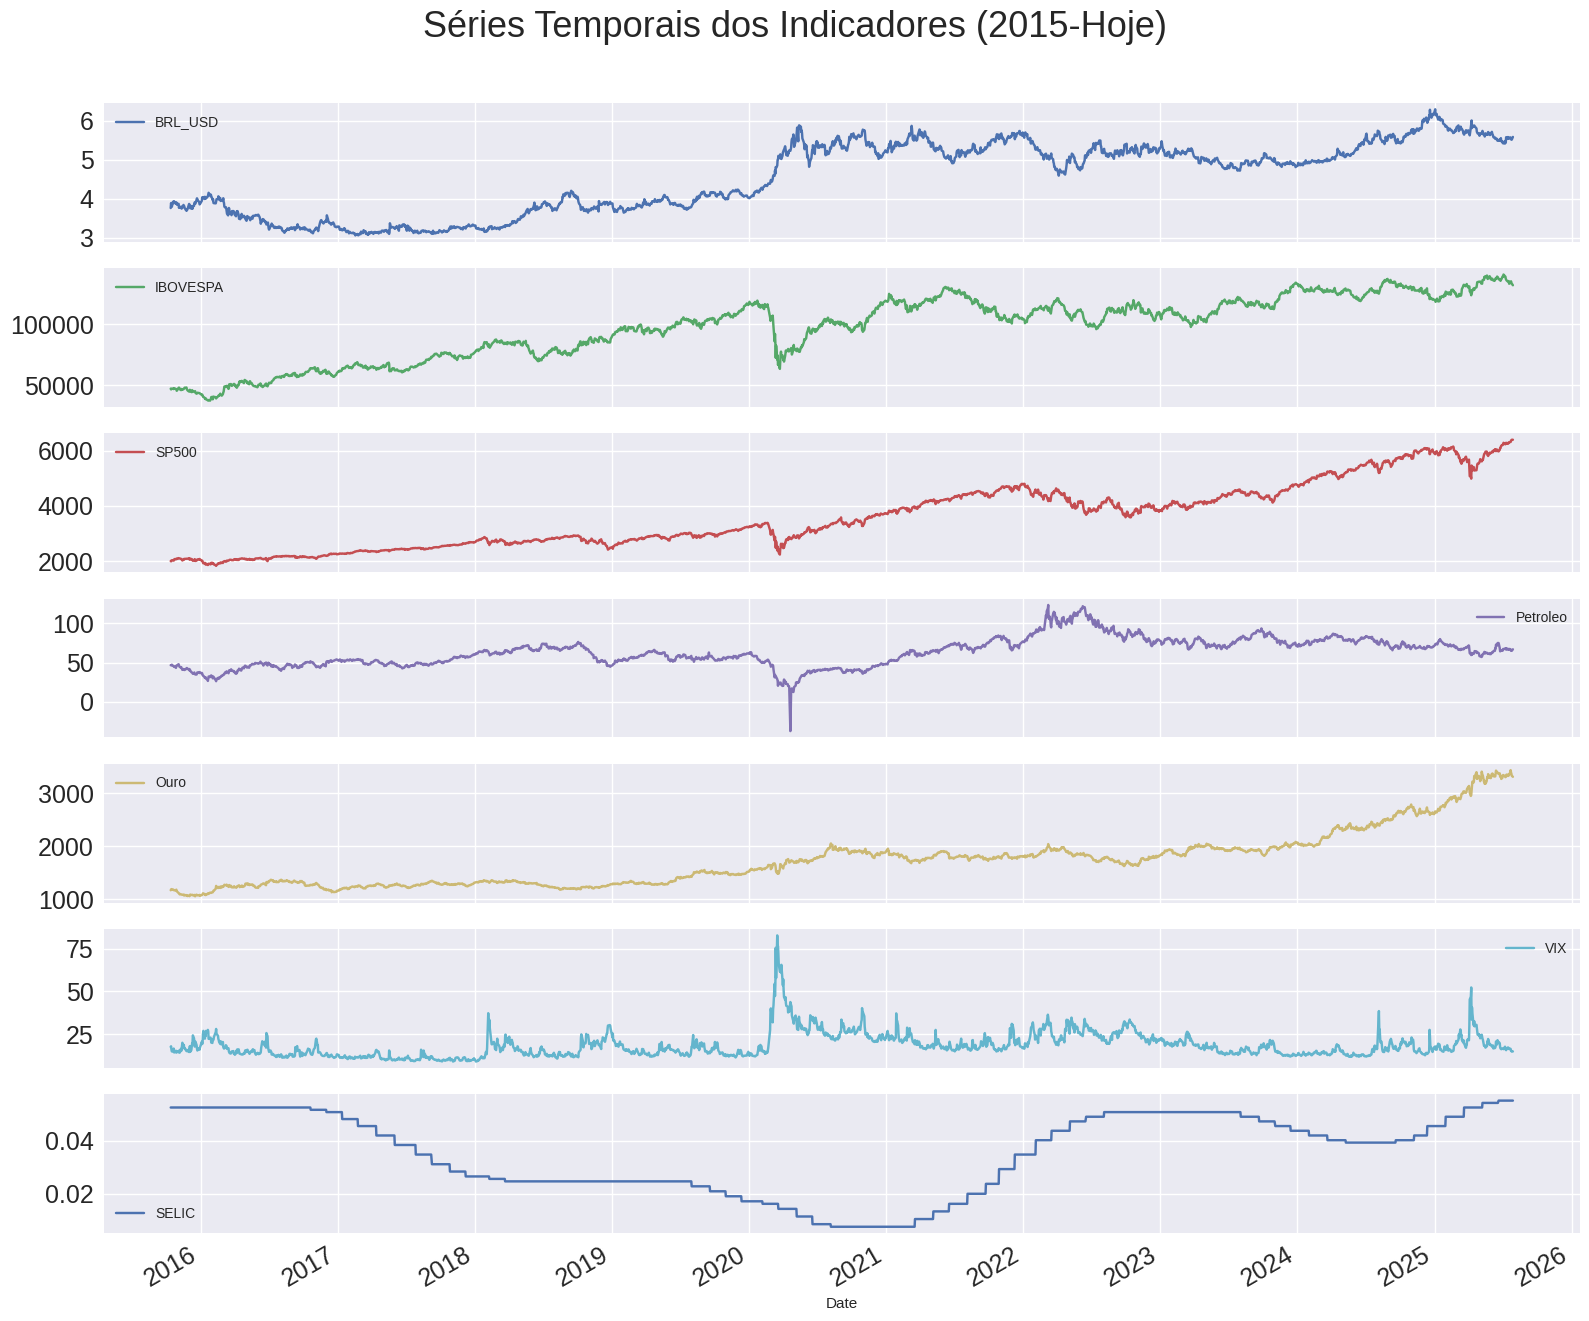

In [ ]:
# Melhorando o gráfico (tamanho do título)
colunas_para_plotar = ['BRL_USD', 'IBOVESPA', 'SP500', 'Petroleo', 'Ouro', 'VIX', 'SELIC']
df[colunas_para_plotar].plot(
    subplots=True,
    layout=(-1, 1),
    figsize=(16, 14),
    # title='Séries Temporais dos Indicadores (2015-Hoje)',
    grid=True,
    legend=True,
    fontsize=18)

plt.suptitle('Séries Temporais dos Indicadores (2015-Hoje)', fontsize=26, y=0.97)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Valorização (1) - O real valorizou, diminuiu a quantidade de reais que precisamos para comprar 1 dolar
Desvalorização (0) - O real aumentou, ou seja, precisa de mais reais para comprar um dolar

In [ ]:
# Criação da coluna alvo que serva para entender valorização (1) ou desvalorização (0)

# Calculo do percentual de retorno dos atributos, funciona como forma de % de quanto aumentou/diminuiu com relação ao dia anterior = (valor atual - valor anterior)/valor_anterior
for col in df.columns:
    if col != 'Alvo': # Evita calcular retorno da coluna Alvo pois ainda não criei
        df[f'{col}_retorno'] = df[col].pct_change()

# Criação dos indicadores técnicos para o BRL/USD
df['BRL_USD_SMA10'] = df['BRL_USD'].rolling(window=10).mean()
df['BRL_USD_SMA50'] = df['BRL_USD'].rolling(window=50).mean()
df['BRL_USD_volatilidade'] = df['BRL_USD_retorno'].rolling(window=20).std()
delta = df['BRL_USD'].diff()
ganho = (delta.where(delta > 0, 0)).rolling(window=14).mean()
perda = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = ganho / perda
df['RSI'] = 100 - (100 / (1 + rs))

# Criação da variável Alvo (fala se valorizou ou não)
horizonte_dias = 5
df['Alvo'] = np.where(df['BRL_USD'].shift(-horizonte_dias) > df['BRL_USD'], 1, 0) # 1=Desvaloriza, 0=Valoriza

# Remove novamente os NaNs gerados pelos indicadores
df.dropna(inplace=True)


In [ ]:
# Vê a base tratada
df

,BRL_USD,Petroleo,Ouro,IBOVESPA,SP500,VIX,SELIC,BRL_USD_retorno,Petroleo_retorno,Ouro_retorno,IBOVESPA_retorno,SP500_retorno,VIX_retorno,SELIC_retorno,BRL_USD_SMA10,BRL_USD_SMA50,BRL_USD_volatilidade,RSI,Alvo
Date,,,,,,,,,,,,,,,,,,,
2015-10-13,3.7605,46.660000,1165.800049,47363.000000,2003.689941,17.670000,0.052531,-0.005659,-0.059843,0.008216,-0.040030,-0.005559,0.034543,0.0,3.92117,3.722422,0.022015,40.125167,1
2015-10-14,3.8888,46.639999,1180.099976,46710.000000,1994.239990,18.030001,0.052531,0.034118,-0.000429,0.012266,-0.013787,-0.004716,0.020374,0.0,3.89968,3.731810,0.023110,43.269802,1
2015-10-15,3.8071,46.380001,1187.900024,47161.000000,2023.859985,16.049999,0.052531,-0.021009,-0.005575,0.006610,0.009655,0.014853,-0.109817,0.0,3.87495,3.738976,0.023454,33.785701,1
2015-10-16,3.7925,47.259998,1183.599976,47236.000000,2033.109985,15.050000,0.052531,-0.003835,0.018974,-0.003620,0.001590,0.004570,-0.062305,0.0,3.85963,3.745500,0.023401,42.257247,1
2015-10-19,3.9207,45.889999,1173.300049,47447.000000,2033.660034,14.980000,0.052531,0.033804,-0.028989,-0.008702,0.004467,0.000271,-0.004651,0.0,3.85182,3.754238,0.024355,47.657108,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-22,5.5655,66.209999,3439.199951,134036.000000,6309.620117,16.500000,0.055131,-0.002259,-0.014732,0.010964,-0.000976,0.000638,-0.009009,0.0,5.55257,5.573929,0.008985,62.623749,0
2025-07-23,5.5639,65.250000,3394.100098,135368.000000,6358.910156,15.370000,0.055131,-0.000287,-0.014499,-0.013113,0.009938,0.007812,-0.068485,0.0,5.56435,5.571975,0.008913,60.326341,0
2025-07-24,5.5164,66.029999,3371.000000,133808.000000,6363.350098,15.390000,0.055131,-0.008537,0.011954,-0.006806,-0.011524,0.000698,0.001301,0.0,5.55781,5.569339,0.009125,58.587854,0


In [ ]:
df.head()
# Pega apenas as 5 primeiras linhas
df_head = df.head()

df_head.style.set_caption("Tabela 2: Exploração dos dados formatados")\
             .set_table_styles([{'selector': 'caption', 'props': [('font-size', '20px')]}])\
             .format("{:.2f}")\
             .highlight_max(color='lightgreen', axis=0)\
             .highlight_min(color='#FFCCCB', axis=0)

,BRL_USD,Petroleo,Ouro,IBOVESPA,SP500,VIX,SELIC,BRL_USD_retorno,Petroleo_retorno,Ouro_retorno,IBOVESPA_retorno,SP500_retorno,VIX_retorno,SELIC_retorno,BRL_USD_SMA10,BRL_USD_SMA50,BRL_USD_volatilidade,RSI,Alvo
Date,,,,,,,,,,,,,,,,,,,
2015-10-13 00:00:00,3.76,46.66,1165.80,47363.00,2003.69,17.67,0.05,-0.01,-0.06,0.01,-0.04,-0.01,0.03,0.00,3.92,3.72,0.02,40.13,1.00
2015-10-14 00:00:00,3.89,46.64,1180.10,46710.00,1994.24,18.03,0.05,0.03,-0.00,0.01,-0.01,-0.00,0.02,0.00,3.90,3.73,0.02,43.27,1.00
2015-10-15 00:00:00,3.81,46.38,1187.90,47161.00,2023.86,16.05,0.05,-0.02,-0.01,0.01,0.01,0.01,-0.11,0.00,3.87,3.74,0.02,33.79,1.00
2015-10-16 00:00:00,3.79,47.26,1183.60,47236.00,2033.11,15.05,0.05,-0.00,0.02,-0.00,0.00,0.00,-0.06,0.00,3.86,3.75,0.02,42.26,1.00
2015-10-19 00:00:00,3.92,45.89,1173.30,47447.00,2033.66,14.98,0.05,0.03,-0.03,-0.01,0.00,0.00,-0.00,0.00,3.85,3.75,0.02,47.66,0.00


Pq a selic fica 0.0 na maioria das vezes? Pra mostrar que ela não está mudando, ela é reajustada (ou não) a cada 45 dias e é caculada como: (valor atual - valor anterior (de ontem)) / valor de ontem

Isso faz pegar a variação da taxa selic

In [ ]:
# Divisao treino e teste do modelo (80/20)
print("\nPreparando dados para o modelo...")
features = [col for col in df.columns if col not in ['BRL_USD', 'Alvo']]
X = df[features]
y = df['Alvo']

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"Tamanho do treino: {len(X_train)} amostras | Tamanho do teste: {len(X_test)} amostras")


Preparando dados para o modelo...
Tamanho do treino: 1885 amostras | Tamanho do teste: 472 amostras


ESSA PARTE DEMORA / É NORMAL

In [ ]:
# Balanceando o modelo, aqui pedimos que ele teste qual o parametro ideal e penalizamos os erros progressivamente sem enviesar o modelo

param_grid_avancado = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_leaf': [20, 30],
    'class_weight': [
        None,                      # Modelo original sem peso
        {0: 2, 1: 1},              # Penaliza 2x mais o erro na classe 0
        {0: 3, 1: 1},              # Penaliza 3x mais o erro na classe 0
        {0: 4, 1: 1},              # Penaliza 4x mais o erro na classe 0
        'balanced'                 # Esse aqui fica muito ruim mesmo
    ]
}

# Validação cruzada para séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# Tenta equilibrar o modelo usando o f1-score para ficar balanceado tanto em valorização quanto para desvalorização
grid_search_avancado = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid_avancado,
    scoring='f1_macro',
    cv=tscv,
    verbose=1
)

# Busca os melhores parâmetros
grid_search_avancado.fit(X_train, y_train)

# Pega o melhor modelo encontrado
best_balanced_model = grid_search_avancado.best_estimator_

print("Melhores parâmetros para o modelo:")
print(grid_search_avancado.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores parâmetros para o modelo:
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 30, 'n_estimators': 100}



Relatório de Classificação:
                    precision    recall  f1-score   support

   Valorização (0)       0.48      0.79      0.60       216
Desvalorização (1)       0.62      0.29      0.39       256

          accuracy                           0.52       472
         macro avg       0.55      0.54      0.50       472
      weighted avg       0.56      0.52      0.49       472



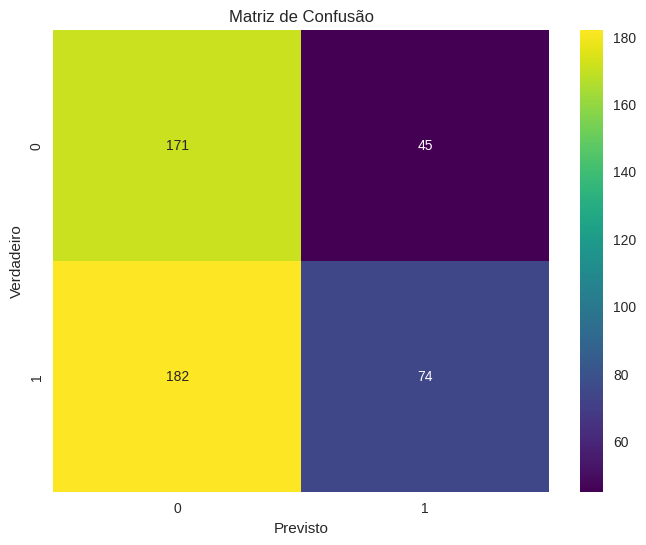

In [ ]:
# Analise do modelo

y_pred_final = best_model.predict(X_test)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_final, target_names=['Valorização (0)', 'Desvalorização (1)']))

cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='viridis')
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

O modelo prevê: VALORIZAÇÃO do Real nos próximos 5 dias.
Probabilidade de Valorização (0): 58.77%
Probabilidade de Desvalorização (1): 41.23%


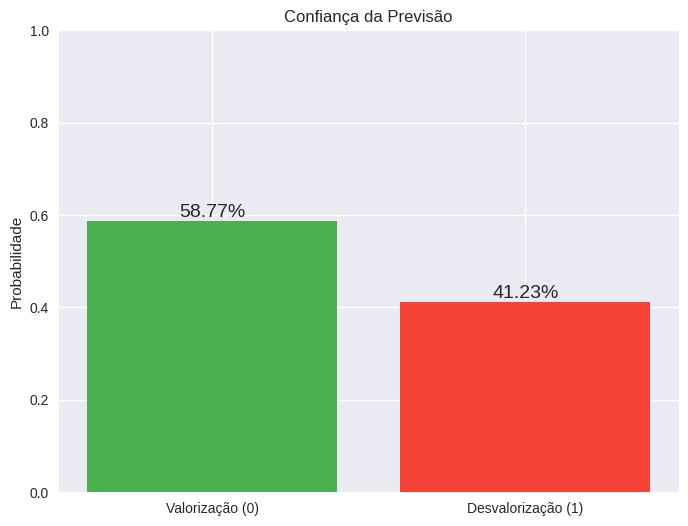

In [ ]:
# Usando o modelo para prever os próximos 5 dias

# Pega a última linha de dados com todas as features para fazer a previsão
last_row = df[features].tail(1)

previsao_final = best_model.predict(last_row)
probabilidades_final = best_model.predict_proba(last_row)

if previsao_final[0] == 1:
    print(f"O modelo prevê: DESVALORIZAÇÃO do Real nos próximos 5 dias.")
else:
    print(f"O modelo prevê: VALORIZAÇÃO do Real nos próximos 5 dias.")

print(f"Probabilidade de Valorização (0): {probabilidades_final[0][0]:.2%}")
print(f"Probabilidade de Desvalorização (1): {probabilidades_final[0][1]:.2%}")

# Gráfico de confiança da previsão
labels = ['Valorização (0)', 'Desvalorização (1)']
probs = [probabilidades_final[0][0], probabilidades_final[0][1]]
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, probs, color=['#4CAF50', '#F44336'])
plt.title('Confiança da Previsão')
plt.ylabel('Probabilidade')
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', ha='center', fontsize=14)
plt.show()

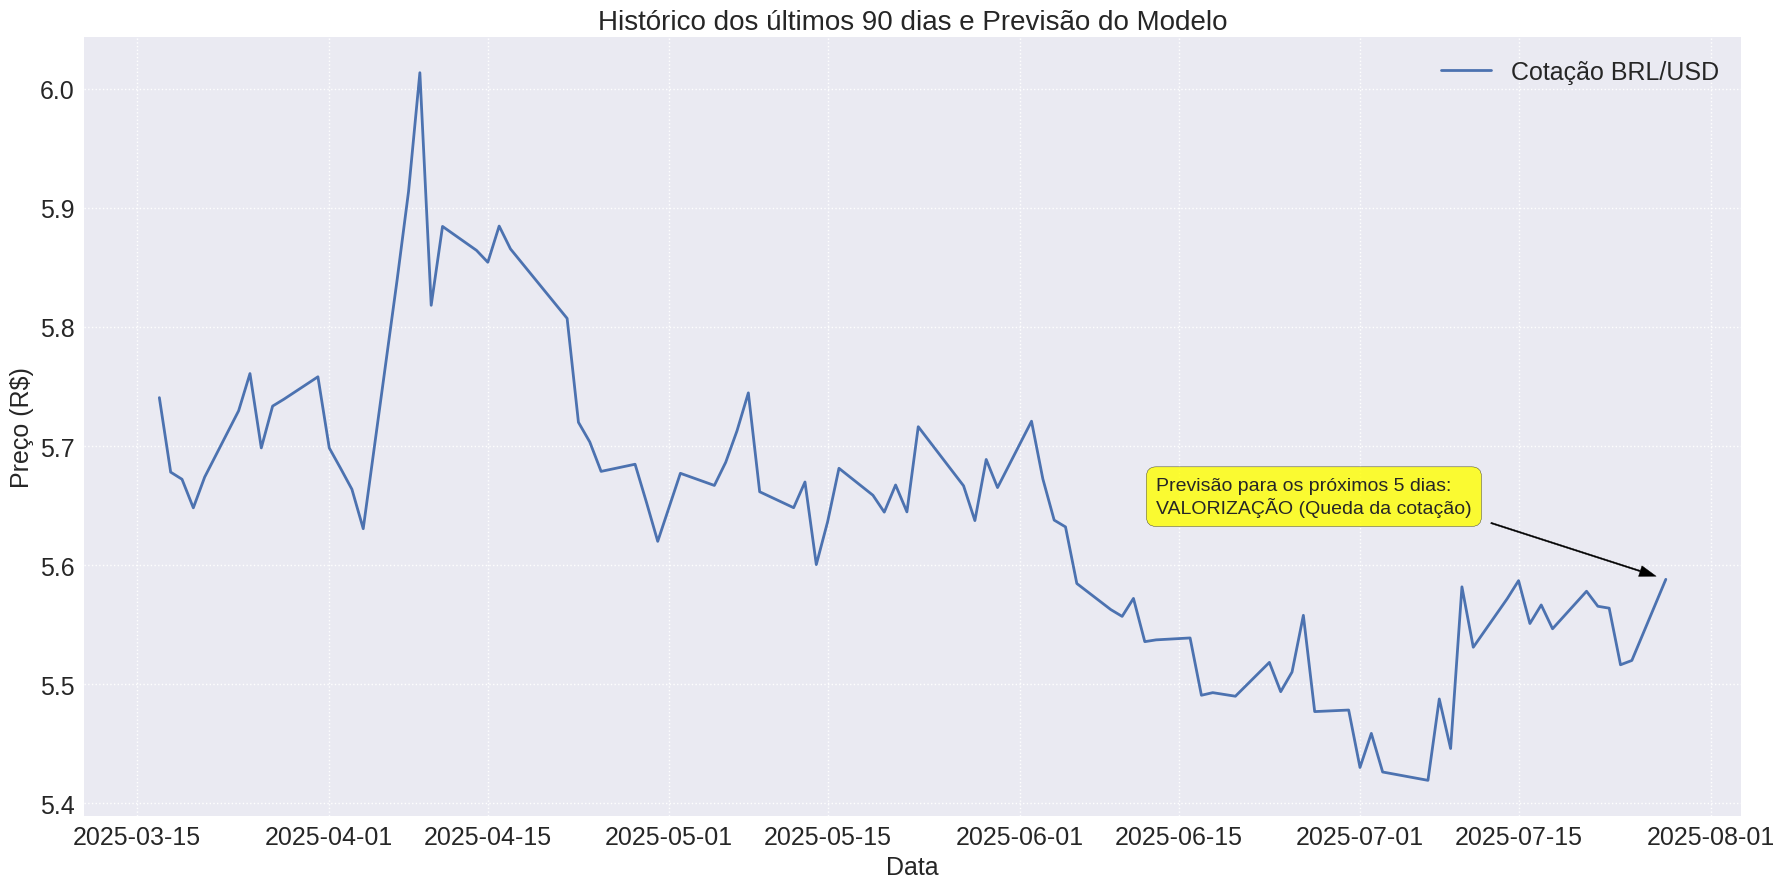

In [ ]:
# Gráfico da previsão

# Pega os últimos 90 dias de dados do dólar
ultimos_90_dias = df['BRL_USD'].tail(90)

# Pego a previsão que já fizemos
if probabilidades_final is not None:
    texto_previsao = "VALORIZAÇÃO (Queda da cotação)" if previsao_final[0] == 0 else "DESVALORIZAÇÃO (Alta da cotação)"
else:
    texto_previsao = "VALORIZAÇÃO (Queda da cotação)" if previsao_final[0] == 0 else "DESVALORIZAÇÃO (Alta da cotação)"

plt.figure(figsize=(18, 9))
plt.plot(ultimos_90_dias.index, ultimos_90_dias.values, label='Cotação BRL/USD', linewidth=2)
plt.title('Histórico dos últimos 90 dias e Previsão do Modelo', fontsize=20)
plt.ylabel('Preço (R$)', fontsize=18)
plt.xlabel('Data', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle=':')

# Anoto a previsão no gráfico (caixinha amarela)
plt.annotate(f'Previsão para os próximos 5 dias:\n{texto_previsao}',
             xy=(ultimos_90_dias.index[-1], ultimos_90_dias.values[-1]), # Posição da seta
             xytext=(ultimos_90_dias.index[-30], ultimos_90_dias.values[-1] * 1.01), # Posição do texto
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=14,
             bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.8))

plt.tight_layout()
plt.show()

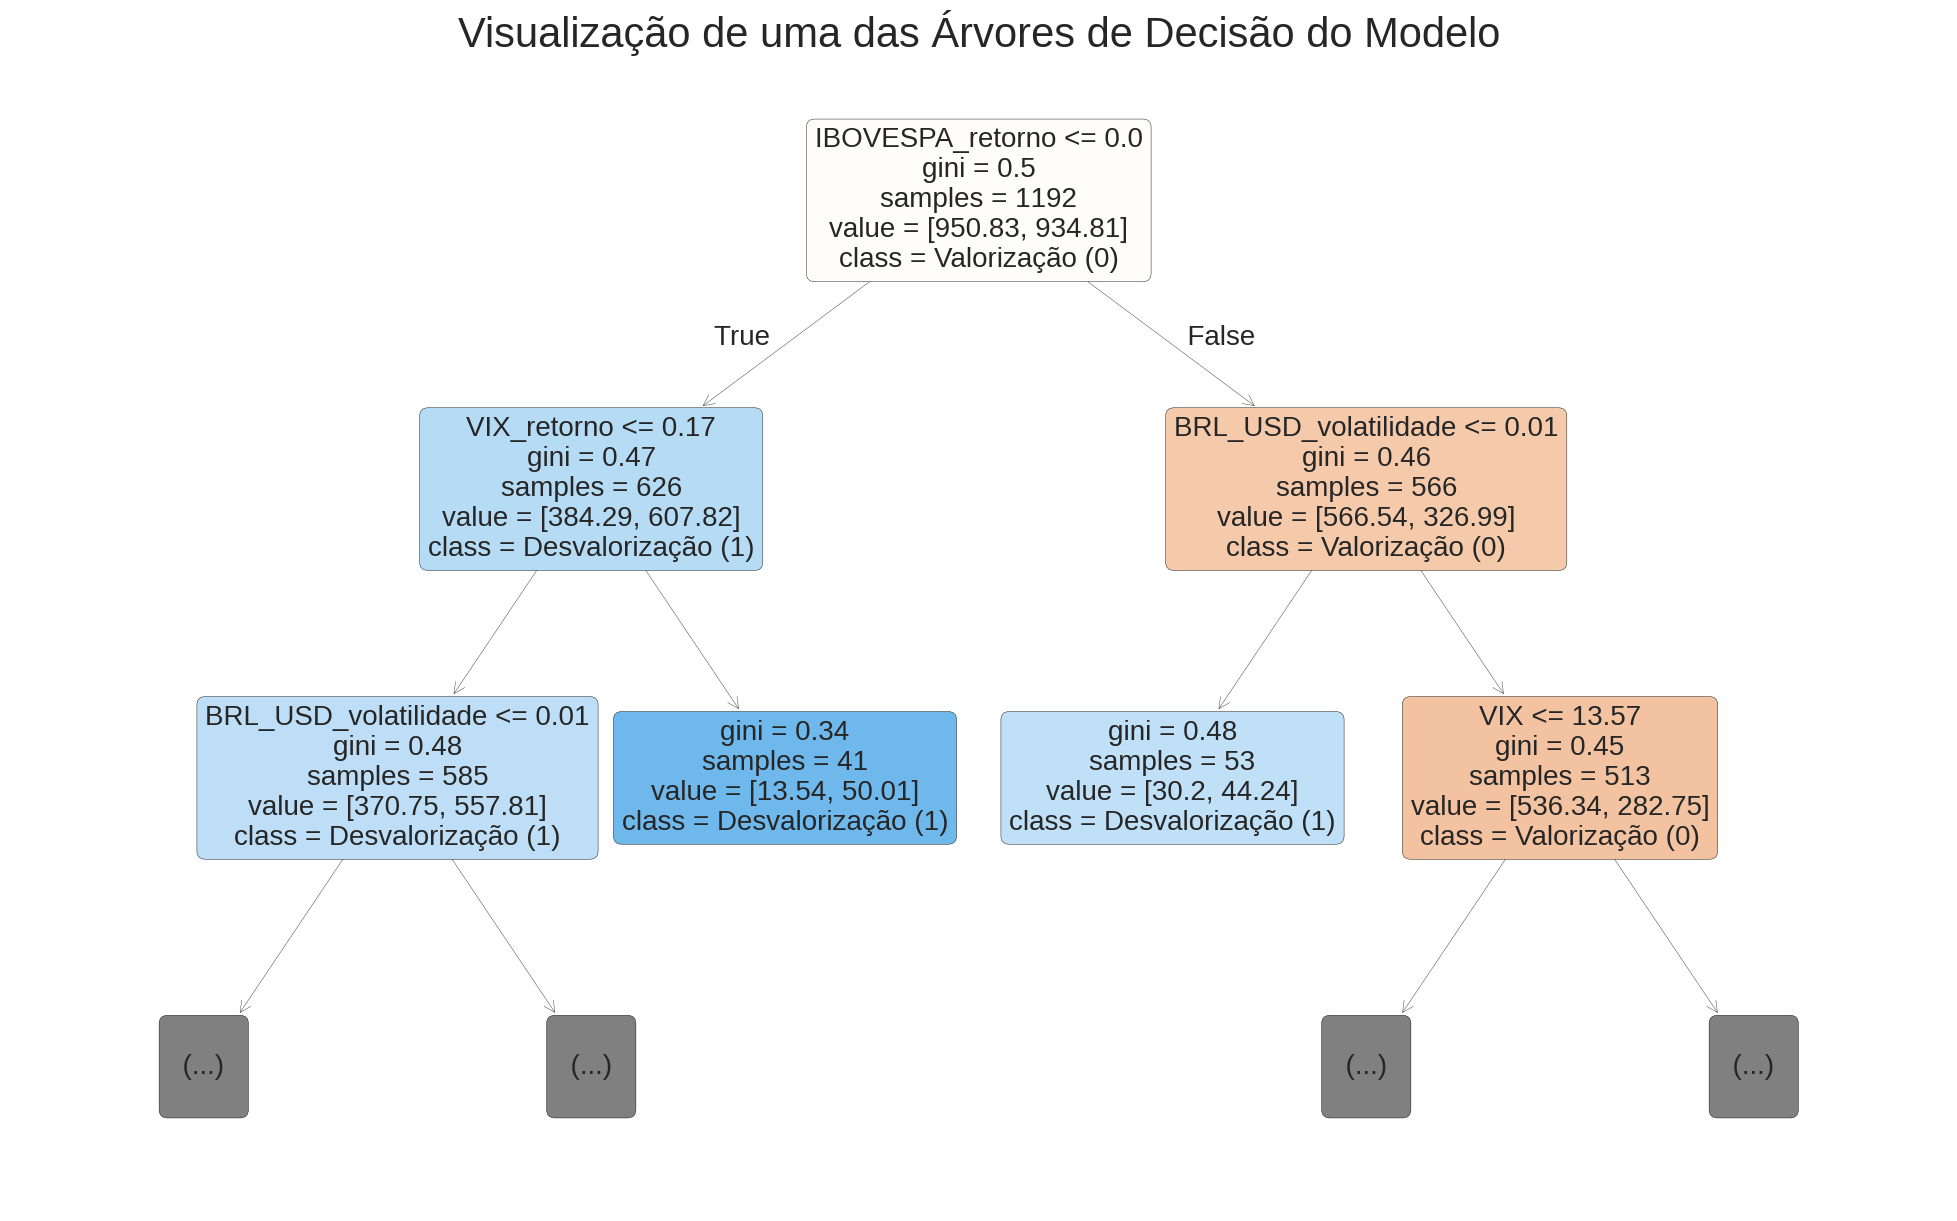

In [ ]:
# Aqui é so para ver uma das arvores, mas fica gigante ai peguei só essa pra não crachar o pc
from sklearn.tree import plot_tree
arvore = best_model.estimators_[0]
plt.figure(figsize=(25, 15))

plot_tree(arvore,
          max_depth=2, #max é a 5
          feature_names=X.columns, # Usa os nomes das nossas features
          class_names=['Valorização (0)', 'Desvalorização (1)'],
          filled=True,
          rounded=True,
          fontsize=20,
          proportion=False,
          precision=2)

plt.title("Visualização de uma das Árvores de Decisão do Modelo", fontsize=30)
plt.show()